In [ ]:
!pip install -q tfds-nightly tensorflow-datasets tensorflow matplotlib

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
from tensorflow.keras.models import Model

In [ ]:
ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, batch_size = -1)

In [ ]:
images, labels = ds['train']

In [ ]:
del ds
#del images
#del labels

In [ ]:
def preprocess(img):
    org = img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    im_max = np.max(sobel)
    im_min = np.min(sobel)
    sobel = (sobel - im_min)/(im_max - im_min)
    sobel = sobel * 255
    sobel = cv2.GaussianBlur(sobel,(3,3),cv2.BORDER_DEFAULT)
    gray = np.expand_dims(gray, axis = 2)
    sobel = np.expand_dims(sobel, axis = 2)
    return np.concatenate([org,gray,sobel], axis = 2)

Load Model

In [ ]:
model  = tf.keras.models.load_model('CNN_Models/3_block_cnn/3_blockV2.h5')
model.compile()

In [ ]:
model.summary()

Model: "2_block_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Original_Image (InputLayer)  [(None, 256, 256, 5)]    0         
                                                                 
 random_flip_29 (RandomFlip)  (None, 256, 256, 5)      0         
                                                                 
 random_rotation_29 (RandomR  (None, 256, 256, 5)      0         
 otation)                                                        
                                                                 
 rescaling_29 (Rescaling)    (None, 256, 256, 5)       0         
                                                                 
 conv2d_114 (Conv2D)         (None, 128, 128, 64)      2944      
                                                                 
 conv2d_115 (Conv2D)         (None, 64, 64, 64)        36928     
                                                       

Using Preprocessing

In [ ]:
#Pick a random image
ind = np.random.randint(0, len(images))

#Format for Neural Network
test = images[ind].numpy()
pre = preprocess(test)
im = np.expand_dims(pre, axis = 0)

Using Model to Predict

In [ ]:
prediction = model.predict(im)
print(f'Prediction is {np.argmax(prediction)}')
print(f'Label is {labels[ind]}')

Prediction is 6
Label is 6


LIME

In [ ]:
pip install lime

9073


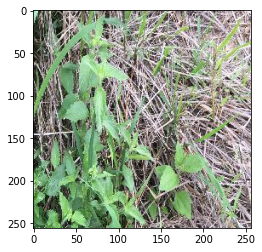

In [ ]:
print(ind)
plt.imshow(images[ind])

Explanation

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [ ]:
def predict(im):
  im = preprocess(im[0])
  im = np.expand_dims(im, axis = 0)
  return model.predict(im)

# Step-by-step LIME

## Step 1: Create perturbations of image

**Extract super-pixels from image**

Superpixels are generated using the quickshift segmentation algorithm.

In [ ]:
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

In [ ]:
superpixels = skimage.segmentation.quickshift(images[ind], kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

55

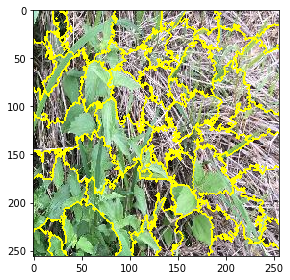

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(images[ind], superpixels))

**Create random perturbations**

A larger number of perturbations will produce more reliable explanations. Random zeros and ones are generated and shaped as a matrix with perturbations as rows and superpixels as columns. 1 represent that a superpixel is on and 0 represents it is off. Notice that the length of the shown vector corresponds to the number of superpixels in the image.

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1])

The function perturb_image perturbs the image based on a perturbation vector (perturbation) and predefined superpixels (segments).

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

Use the previous function to see what a perturbed image would look like:

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


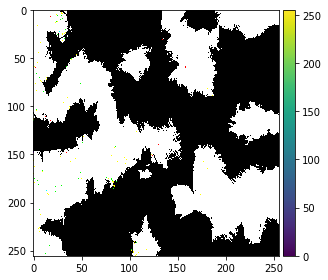

In [ ]:
skimage.io.imshow(perturb_image(images[ind].numpy(),perturbations[0],superpixels))

##Step 2: Use ML classifier to predict classes of new generated images
This is the most computationally expensive step in LIME because a prediction for each perturbed image is computed. From the shape of the predictions we can see for each of the perturbations we have the output probability for each of the 9 classes.

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(images[ind],pert,superpixels)
  pred = predict(perturbed_img[np.newaxis,:,:,:].numpy())
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 9)

##Step 3: Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image
The distance between each randomly generated perturnation and the image being explained is computed using the cosine distance. For the shape of the distances array it can be noted that, as expected, there is a distance for every generated perturbation.

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

**Use kernel function to compute weights**

The distances are then mapped to a value between zero and one (weight) using a kernel function. An example of a kernel function with different kernel widths is shown in the plot below. Here the x axis represents distances and the y axis the weights. Depeding on how we set the kernel width, it defines how wide we want the "locality" around our instance to be. This kernel width can be set based on expected distance values. For the case of cosine distances, we expect them to be somehow stable (between 0 and 1); therefore, no fine tunning of the kernel width might be required.

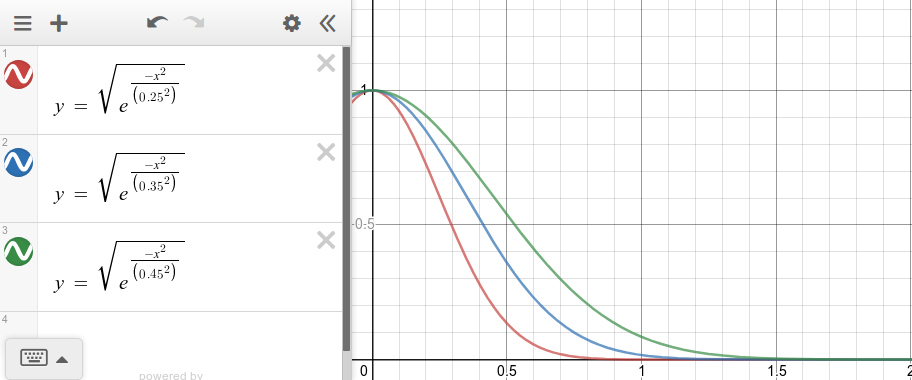

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

##Step 4: Use perturbations, predictions and weights to fit an explainable (linear) model
A weighed linear regression model is fitted using data from the previous steps (perturbations, predictions and weights). Given that the class that we want to explain is labrador, when fitting the linear model we take from the predictions vector only the column corresponding to the top predicted class. Each coefficients in the linear model corresponds to one superpixel in the segmented image. These coefficients represent how important is each superpixel for the prediction of labrador.

In [ ]:
preds = predict(images[ind][np.newaxis,:,:,:].numpy())

In [ ]:
print(preds)

[[2.9222560e-10 1.1230808e-11 1.7455636e-11 4.4620999e-10 6.1024003e-10
  4.4128464e-15 1.0000000e+00 2.8516480e-08 4.8515703e-10]]


In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([6, 7, 4, 8, 3])

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.05668388, -0.03053482,  0.07941512,  0.03288432, -0.01371143,
       -0.02080212, -0.01771059,  0.0276132 , -0.09529483,  0.01853789,
       -0.0064427 ,  0.01147632,  0.01163848, -0.01286726, -0.00168818,
        0.0076429 ,  0.05669437, -0.01927148,  0.04279334,  0.02148106,
       -0.02367647,  0.01777266,  0.07505745,  0.02311935,  0.07601984,
        0.0447773 ,  0.00032258, -0.01488373,  0.04003687,  0.05108463,
       -0.01557715, -0.04669418, -0.01010928,  0.0024629 ,  0.01020447,
        0.08078315, -0.01600568, -0.0396755 ,  0.01898601, -0.02623007,
       -0.00879708, -0.02100587, -0.02035509,  0.03994443,  0.00968471,
        0.04413347, -0.02515794,  0.04160101, -0.00074453,  0.0089757 ,
        0.08162267,  0.00051164, -0.02803608, -0.00439468,  0.0424858 ])

**Compute top features (superpixels)**

Sort the coefficients to figure out which are the supperpixels that have larger coefficients (magnitude) for the prediction of labradors. The identifiers of these top features or superpixels are shown below. Even though here we use the magnitude of the coefficients to determine the most important features, other alternatives such as forward or backward elimination can be used for feature importance selection.

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([24,  2, 35, 50])

**Show LIME explanation (image with top features)**

Show the most important superpixels defined in the previous step in an image after covering up less relevant superpixels.

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


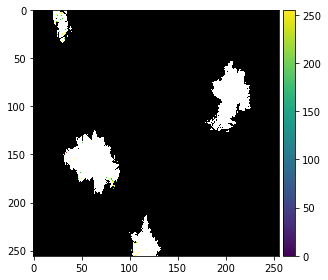

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(images[ind].numpy(),mask,superpixels) )